In [50]:
# Week 4

In [51]:
# conda install -c conda-forge pyomo

In [52]:
# conda install -c conda-forge glpk

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path



In [54]:
from pyomo.environ import *
from pyomo.gdp import *

In [55]:
# conda install -c conda-forge pyomo

In [43]:
TASKS = {
    ('Part_1','Mach_2')   : {'dur': 45, 'prec': None},
    ('Part_1','Mach_3') : {'dur': 10, 'prec': ('Part_1','Mach_2')},
    ('Part_2','Mach_2')   : {'dur': 20, 'prec': ('Part_2','Mach_1')},
    ('Part_2','Mach_1')  : {'dur': 10, 'prec': None},
    ('Part_2','Mach_3') : {'dur': 34, 'prec': ('Part_2','Mach_2')},
    ('Part_3','Mach_2')   : {'dur': 12, 'prec': ('Part_3','Mach_3')},
    ('Part_3','Mach_1')  : {'dur': 17, 'prec': ('Part_3','Mach_2')},
    ('Part_3','Mach_3') : {'dur': 28, 'prec': None},   
}

In [44]:
# each part is a job
# tasks are the actions to finish a job

In [45]:
def jobshop_model(TASKS):
    
    # initiate the model    
    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    # ('Part_1','Mach_2')
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)
    
    # the set of jobs is constructed from a python set
    # one dimensional
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))
    
    # set of machines is constructed from a python set
    # one dimensional
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))
    
    
    # for all pairs of two tasks, 
    # second pair (j,m)
    # first  pair (k,n)
    # if (k,n) == the value in the 'prec' 
    # meaning the precessor matches the require process plan
    # make the value for (j,m,k,n) is a true
    # e.g., ('Part_1','Mach_3','Part_1','Mach_2') = true 
    # becasue in the given tasks
    # ('Part_1','Mach_3') : {'dur': 10, 'prec': ('Paper_1','Mach_2')},
    ######################################################################
    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4, 
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])
    
    ############################################################################
    # indicator for whether two jobs are using the same machine
    # the set of disjunctions is cross-product of jobs, jobs, and machines

    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j != k and (j,m) in model.TASKS and (k,m) in model.TASKS)
    
    # get durations
    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    # the upper bound for makespan is the total duration
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])
    
    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))
    
    # define objective
    model.objective = Objective(expr = model.makespan, sense = minimize)

    # define what is the make span
    # finishing time for all jobs
    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:  
        model.start[j,m] + model.dur[j,m] <= model.makespan)
    
    # precessor must be finished before the next task starts
    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n: 
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])
    
    # one mach can do one task at a time
    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m], 
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])
    
    # need the following for integer programming models
    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [46]:
# conda install -c conda-forge glpk
# cannot do import glpk

In [47]:
def jobshop_solve(model):
    SolverFactory('glpk').solve(model)
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': model.dur[j,m], 
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'Part_1',
  'Machine': 'Mach_2',
  'Start': 42.0,
  'Duration': 45,
  'Finish': 87.0},
 {'Job': 'Part_1',
  'Machine': 'Mach_3',
  'Start': 87.0,
  'Duration': 10,
  'Finish': 97.0},
 {'Job': 'Part_2',
  'Machine': 'Mach_2',
  'Start': 10.0,
  'Duration': 20,
  'Finish': 30.0},
 {'Job': 'Part_2',
  'Machine': 'Mach_1',
  'Start': 0.0,
  'Duration': 10,
  'Finish': 10.0},
 {'Job': 'Part_2',
  'Machine': 'Mach_3',
  'Start': 30.0,
  'Duration': 34,
  'Finish': 64.0},
 {'Job': 'Part_3',
  'Machine': 'Mach_2',
  'Start': 30.0,
  'Duration': 12,
  'Finish': 42.0},
 {'Job': 'Part_3',
  'Machine': 'Mach_1',
  'Start': 42.0,
  'Duration': 17,
  'Finish': 59.0},
 {'Job': 'Part_3',
  'Machine': 'Mach_3',
  'Start': 2.0,
  'Duration': 28,
  'Finish': 30.0}]

In [48]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                Start  Duration  Finish
Job    Machine                         
Part_1 Mach_2    42.0        45    87.0
       Mach_3    87.0        10    97.0
Part_2 Mach_1     0.0        10    10.0
       Mach_2    10.0        20    30.0
       Mach_3    30.0        34    64.0
Part_3 Mach_3     2.0        28    30.0
       Mach_2    30.0        12    42.0
       Mach_1    42.0        17    59.0

Schedule by Machine
                Start  Duration  Finish
Machine Job                            
Mach_1  Part_2    0.0        10    10.0
        Part_3   42.0        17    59.0
Mach_2  Part_2   10.0        20    30.0
        Part_3   30.0        12    42.0
        Part_1   42.0        45    87.0
Mach_3  Part_3    2.0        28    30.0
        Part_2   30.0        34    64.0
        Part_1   87.0        10    97.0


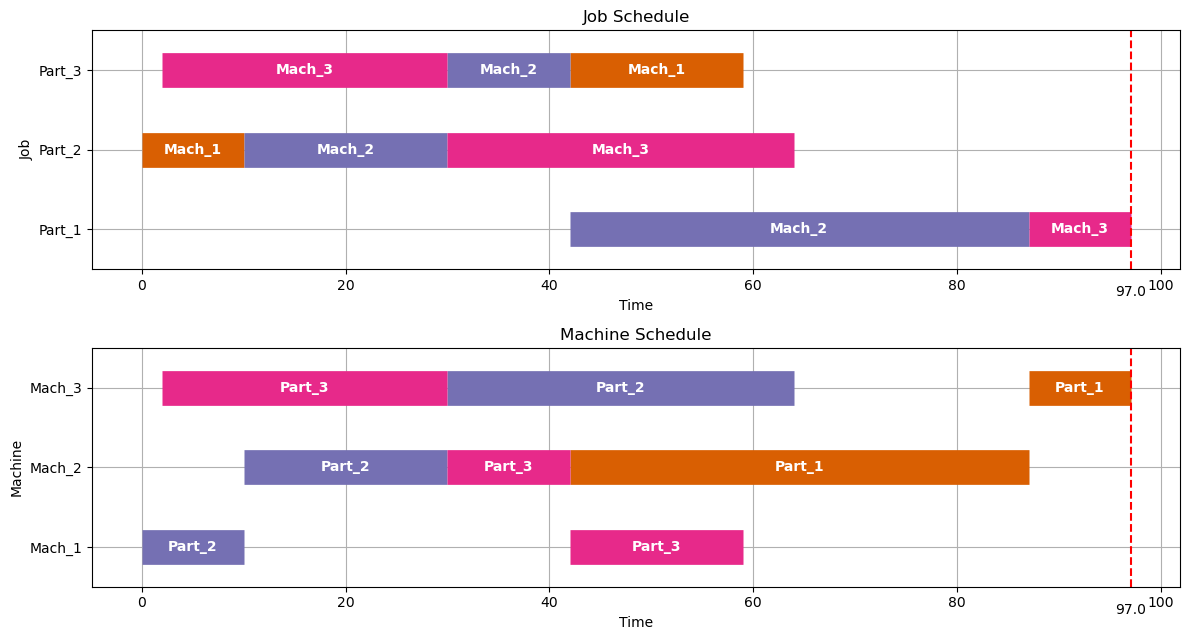

In [49]:
def visualize(results):
    
    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

visualize(results)

In [81]:
############################################
## robust optimizations

In [82]:
Possibile_durP1M2 = [32,31,35,54,39,33, 44,45,56,75,73] 

In [83]:
durP1M2 = max(Possibile_durP1M2)
durP1M2

75

In [ ]:
# robust optimization with budget of uncertainty
# gamma

In [112]:
from statistics import mean 
gamma = 0.8
durP1M2 = (mean(Possibile_durP1M2)) + gamma*0.5*(max(Possibile_durP1M2) - min(Possibile_durP1M2))
durP1M2

In [113]:
# durP1M2 = 45

In [114]:
TASKS_uncertaity = {
    ('Part_1','Mach_2')   : {'dur': durP1M2, 'prec': None},
    ('Part_1','Mach_3') : {'dur': 10, 'prec': ('Part_1','Mach_2')},
    ('Part_2','Mach_2')   : {'dur': 20, 'prec': ('Part_2','Mach_1')},
    ('Part_2','Mach_1')  : {'dur': 10, 'prec': None},
    ('Part_2','Mach_3') : {'dur': 34, 'prec': ('Part_2','Mach_2')},
    ('Part_3','Mach_2')   : {'dur': 12, 'prec': ('Part_3','Mach_3')},
    ('Part_3','Mach_1')  : {'dur': 17, 'prec': ('Part_3','Mach_2')},
    ('Part_3','Mach_3') : {'dur': 28, 'prec': None},   
}

In [115]:
def jobshop_solve(model):
    SolverFactory('glpk').solve(model)
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': model.dur[j,m], 
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS_uncertaity):
    return jobshop_solve(jobshop_model(TASKS_uncertaity))

results = jobshop(TASKS_uncertaity)
results

[{'Job': 'Part_1',
  'Machine': 'Mach_2',
  'Start': 42.0,
  'Duration': 64.6,
  'Finish': 106.6},
 {'Job': 'Part_1',
  'Machine': 'Mach_3',
  'Start': 106.6,
  'Duration': 10,
  'Finish': 116.6},
 {'Job': 'Part_2',
  'Machine': 'Mach_2',
  'Start': 10.0,
  'Duration': 20,
  'Finish': 30.0},
 {'Job': 'Part_2',
  'Machine': 'Mach_1',
  'Start': 0.0,
  'Duration': 10,
  'Finish': 10.0},
 {'Job': 'Part_2',
  'Machine': 'Mach_3',
  'Start': 72.6,
  'Duration': 34,
  'Finish': 106.6},
 {'Job': 'Part_3',
  'Machine': 'Mach_2',
  'Start': 30.0,
  'Duration': 12,
  'Finish': 42.0},
 {'Job': 'Part_3',
  'Machine': 'Mach_1',
  'Start': 42.0,
  'Duration': 17,
  'Finish': 59.0},
 {'Job': 'Part_3',
  'Machine': 'Mach_3',
  'Start': 2.0,
  'Duration': 28,
  'Finish': 30.0}]

In [116]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                Start  Duration  Finish
Job    Machine                         
Part_1 Mach_2    42.0      64.6   106.6
       Mach_3   106.6      10.0   116.6
Part_2 Mach_1     0.0      10.0    10.0
       Mach_2    10.0      20.0    30.0
       Mach_3    72.6      34.0   106.6
Part_3 Mach_3     2.0      28.0    30.0
       Mach_2    30.0      12.0    42.0
       Mach_1    42.0      17.0    59.0

Schedule by Machine
                Start  Duration  Finish
Machine Job                            
Mach_1  Part_2    0.0      10.0    10.0
        Part_3   42.0      17.0    59.0
Mach_2  Part_2   10.0      20.0    30.0
        Part_3   30.0      12.0    42.0
        Part_1   42.0      64.6   106.6
Mach_3  Part_3    2.0      28.0    30.0
        Part_2   72.6      34.0   106.6
        Part_1  106.6      10.0   116.6


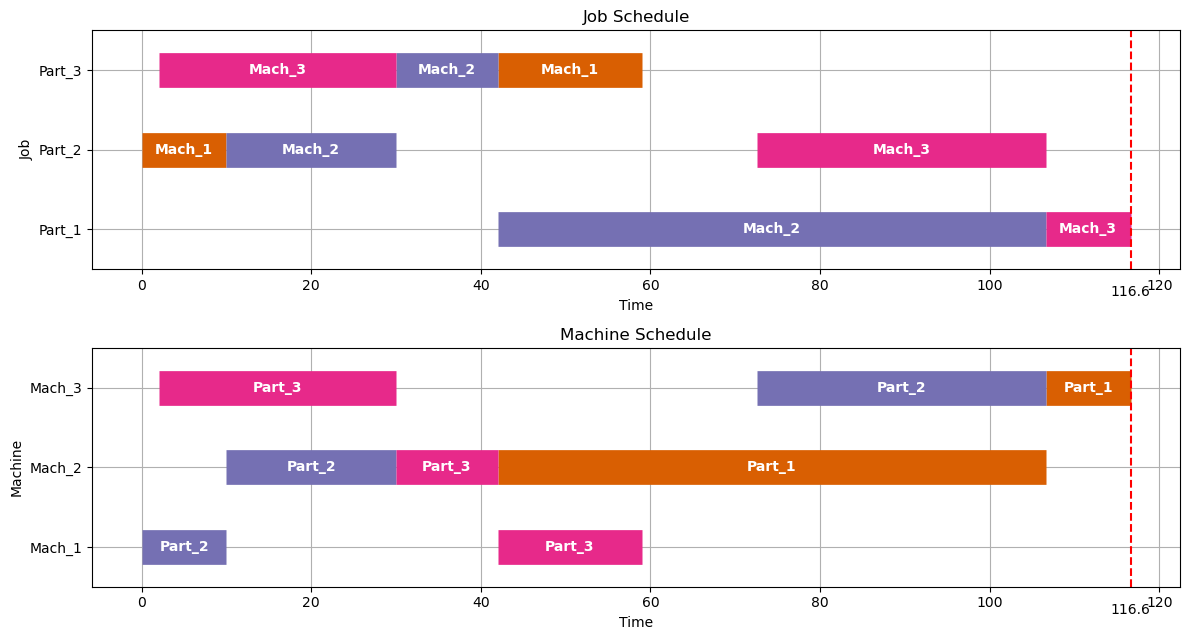

In [117]:
visualize(results)

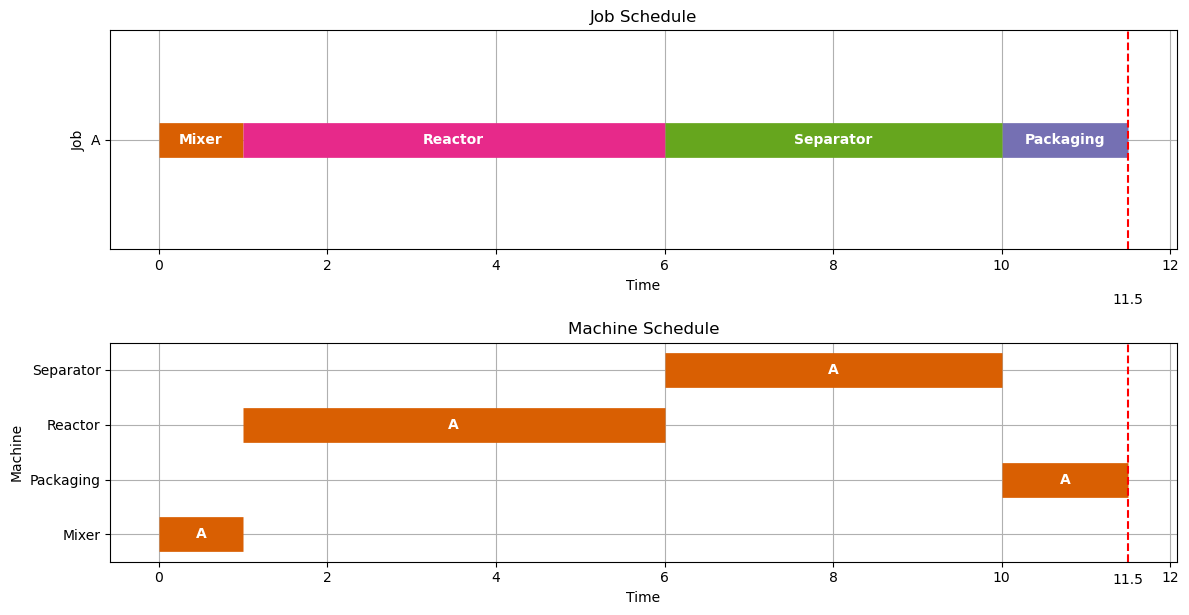

In [28]:
def recipe_to_tasks(jobs, machines, durations):
    TASKS = {}
    for j in jobs:
        prec = (None,None)
        for m,d in zip(machines,durations):
            task = (j,m)
            if prec == (None,None):
                TASKS.update({(j,m): {'dur': d, 'prec': None}})
            else:
                TASKS.update({(j,m): {'dur': d, 'prec': prec}})
            prec = task
    return TASKS
        
recipeA = recipe_to_tasks('A', ['Mixer', 'Reactor', 'Separator', 'Packaging'], [1, 5, 4, 1.5])
visualize(jobshop(recipeA))

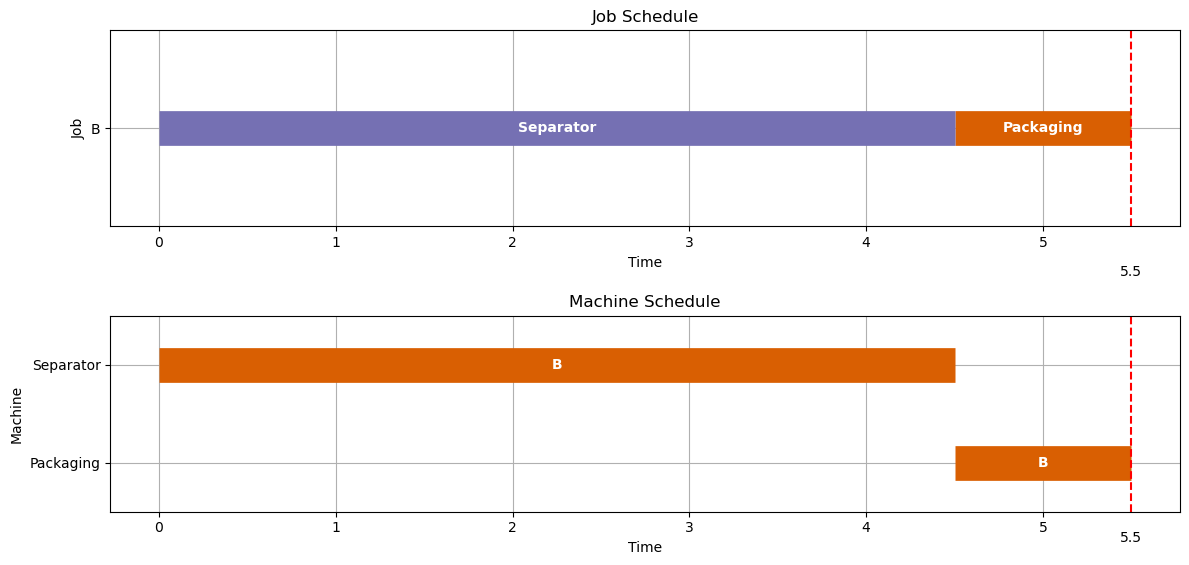

In [29]:
recipeB = recipe_to_tasks('B', ['Separator', 'Packaging'], [4.5, 1])
visualize(jobshop(recipeB))

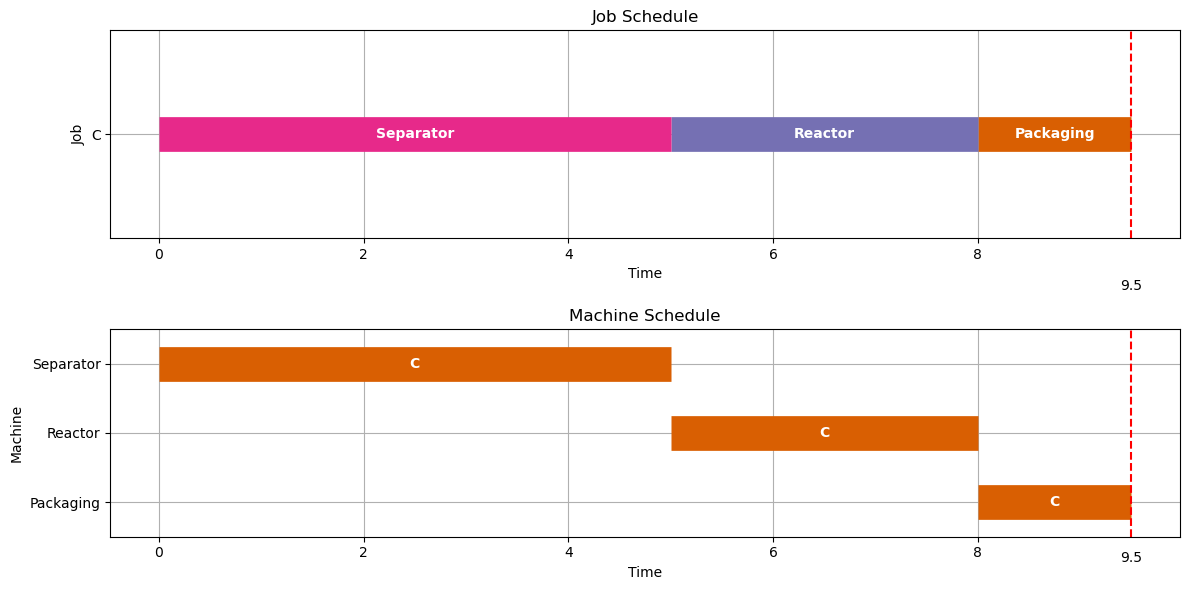

In [30]:
recipeC = recipe_to_tasks('C', ['Separator', 'Reactor', 'Packaging'], [5, 3, 1.5])
visualize(jobshop(recipeC))

Makespan = 26.5


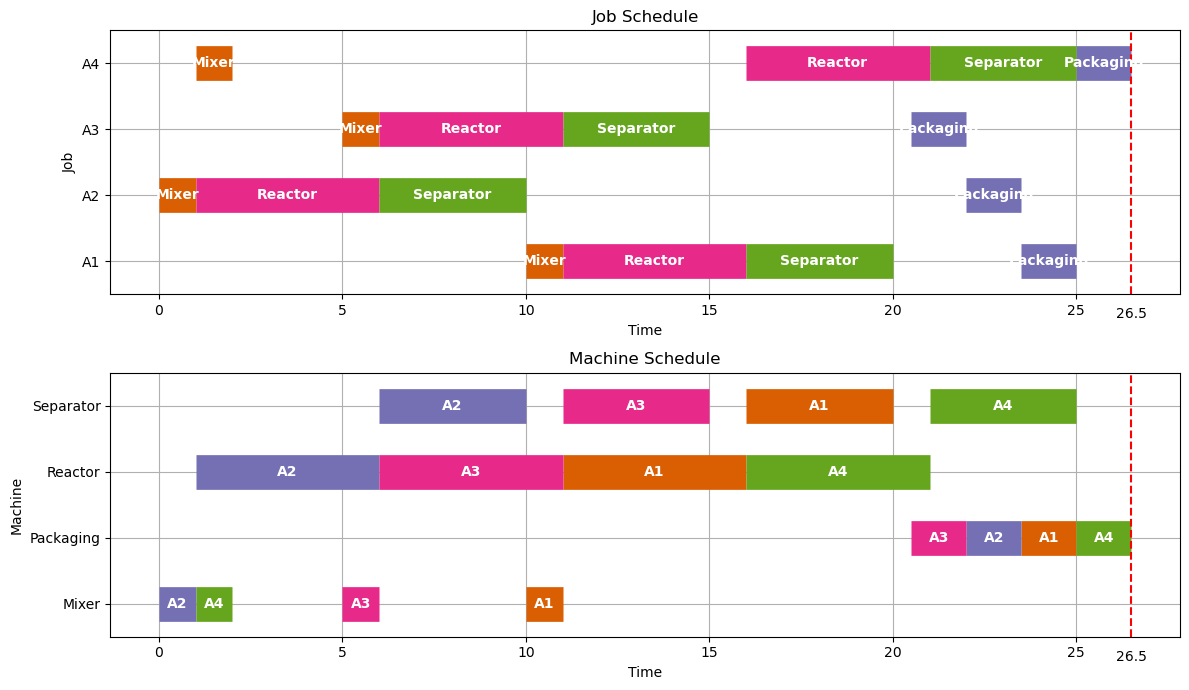

In [31]:
TASKS = recipe_to_tasks(['A1','A2','A3', 'A4'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

('A', 'Mixer') {'dur': 1, 'prec': None}
('A', 'Reactor') {'dur': 5, 'prec': ('A', 'Mixer')}
('A', 'Separator') {'dur': 4, 'prec': ('A', 'Reactor')}
('A', 'Packaging') {'dur': 1.5, 'prec': ('A', 'Separator')}
('B', 'Separator') {'dur': 4.5, 'prec': None}
('B', 'Packaging') {'dur': 1, 'prec': ('B', 'Separator')}
('C', 'Separator') {'dur': 5, 'prec': None}
('C', 'Reactor') {'dur': 3, 'prec': ('C', 'Separator')}
('C', 'Packaging') {'dur': 1.5, 'prec': ('C', 'Reactor')}
Makespan = 15.0


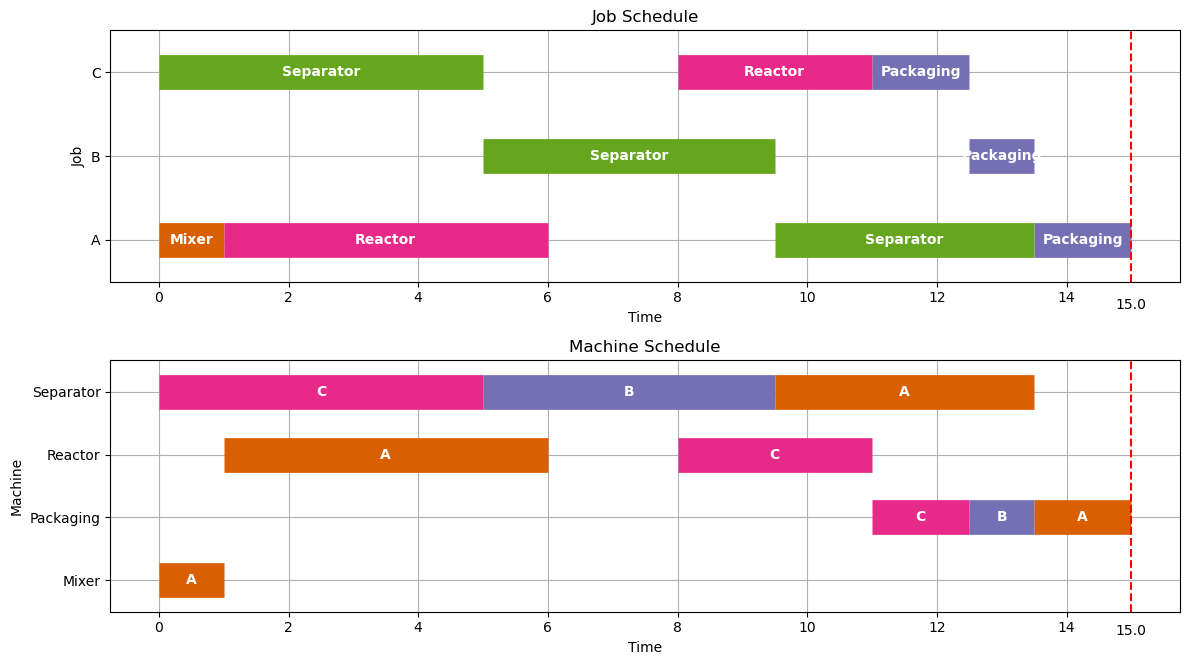

In [32]:
# update is used to append dictionaries
TASKS = recipeA
TASKS.update(recipeB)
TASKS.update(recipeC)

for k, v in TASKS.items():
    print(k, v)

results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

Makespan = 28.0


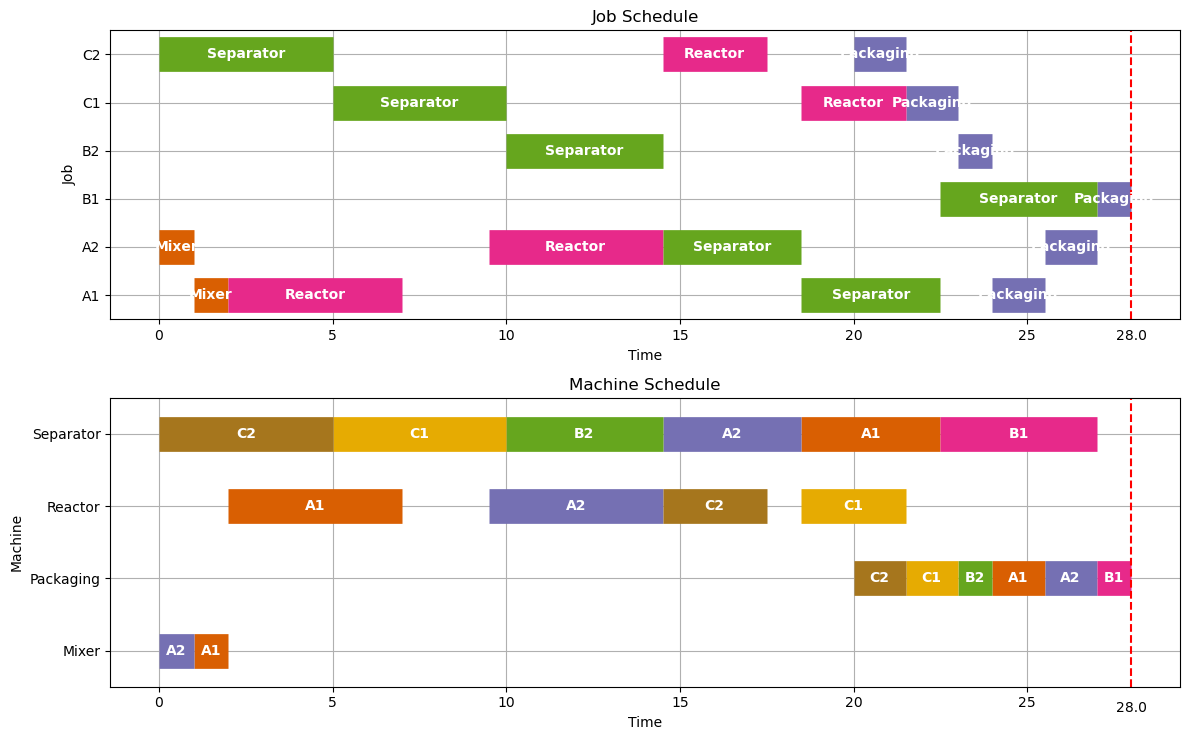

In [33]:
TASKS = recipe_to_tasks(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
TASKS.update(recipe_to_tasks(['B1','B2'],['Separator','Packaging'],[4.5,1]))
TASKS.update(recipe_to_tasks(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

Makespan = 30.5


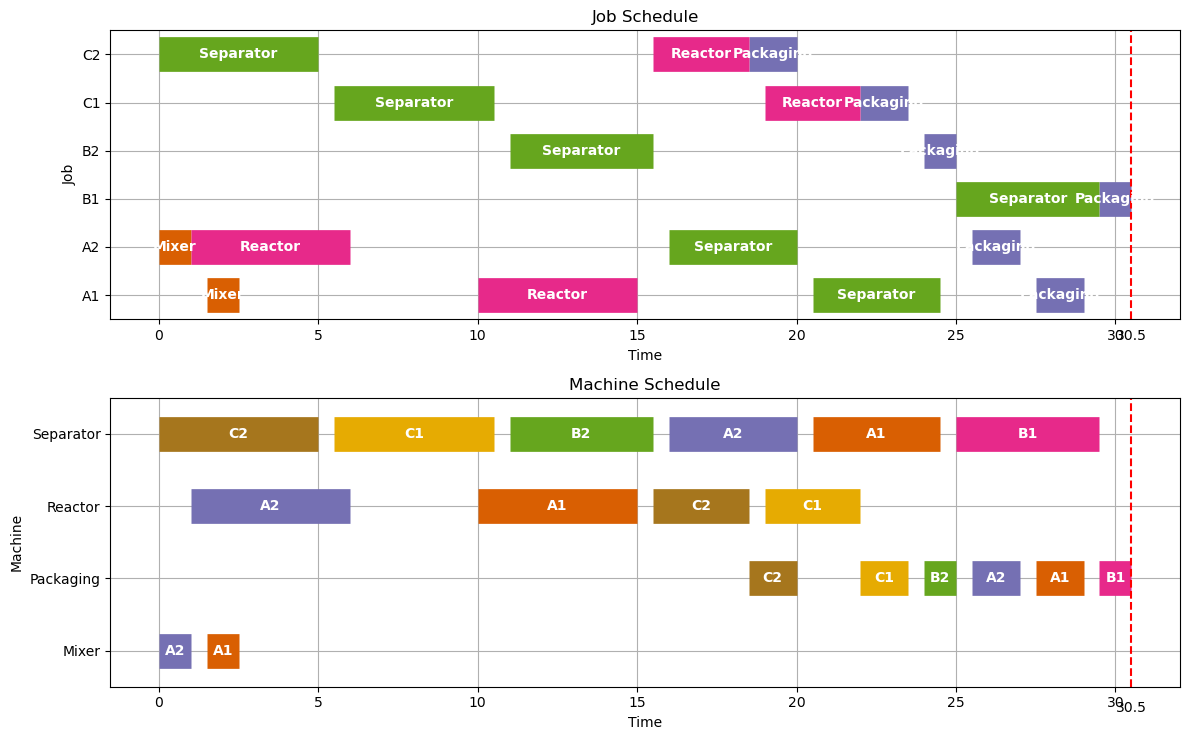

In [34]:
def jobshop_model_clean(TASKS, tclean=0):
   
    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)
    
    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))
    
    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))
    
    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4, 
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])
    
    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)
    
    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j,m] for (j,m) in model.TASKS])
    
    model.makespan = Var(bounds=(0, ub))

    model.start = Var(model.TASKS, bounds=(0, ub))
    
    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:  
        model.start[j,m] + model.dur[j,m] <= model.makespan)
    
    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n: 
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])
    
    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] + tclean <= model.start[k,m], 
         model.start[k,m] + model.dur[k,m] + tclean <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

model = jobshop_model_clean(TASKS, tclean=0.5)
results = jobshop_solve(model)
visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))